# Load Libraries & Dataset
## Libraries

In [1]:
%cd ../..

C:\Users\fahmi\Documents\Github ML Project\time-series-projects


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.utils.general import LogTime
from src.utils.ts_utils import forecast_bias
from src.forecasting.baselines import NaiveMovingAverage
from src.transforms.stationary_utils import check_unit_root, check_trend, check_deterministic_trend, check_seasonality, check_heteroscedastisticity
from src.transforms.target_transformations import AutoStationaryTransformer, BoxCoxTransformer

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from darts.models import NaiveSeasonal, ExponentialSmoothing, Theta, ARIMA, AutoARIMA, FFT
from darts import TimeSeries
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mase, mse, mae, ope
from darts.metrics.metrics import _get_values_or_raise
from darts.metrics import metrics as dart_metrics

C:\Users\fahmi\AppData\Local\Temp\ipykernel_10948\3986604241.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\utils\data_utils.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Dataset

In [3]:
energy = pd.read_csv('energy-consumption/datasets/energy_consumption.csv', 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']
energy.index.freq = 'MS'
energy

y
Month               
1973-01-01  1957.641
1973-02-01  1712.143
1973-03-01  1510.079
1973-04-01  1183.421
1973-05-01  1006.326
...              ...
2021-08-01  1755.212
2021-09-01  1456.901
2021-10-01  1315.799
2021-11-01  1644.306
2021-12-01  2032.352

[588 rows x 1 columns]

In [4]:
energy.describe()

y
count   588.000000
mean   1551.824029
std     403.939753
min     901.700000
25%    1251.331250
50%    1466.218500
75%    1810.309750
max    2808.412000

In [5]:
energy.isnull().sum()

y    0
dtype: int64

C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\transforms\target_transformations.py:545: UserWarning: Trends with degree>1 are very strong and use with care.
  warnings.warn("Trends with degree>1 are very strong and use with care.")
C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\decomposition\seasonal.py:36: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return lambda x: X.__class__(x, index=index, name=names)


Transformations applied: ['DetrendingTransformer', 'DeseasonalizingTransformer', 'AddMTransformer', 'BoxCoxTransformer']


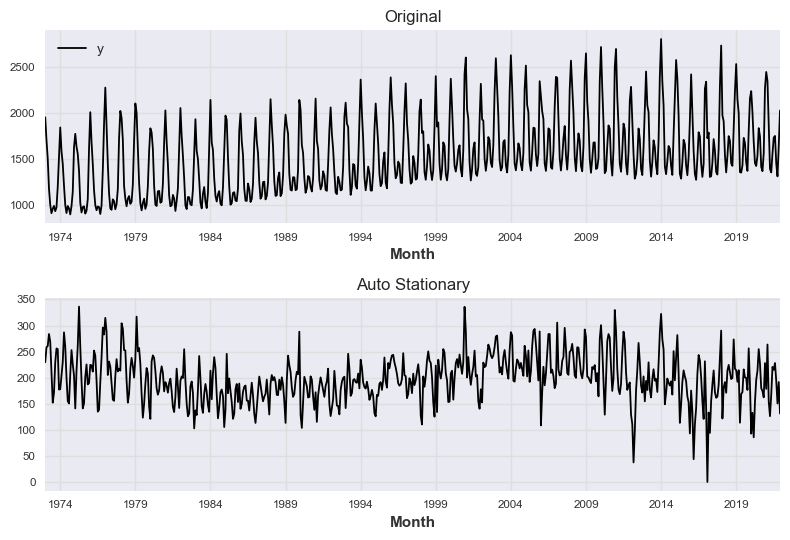

Unit Root: True with a p-value of 0.01370598509593634
Inverse == Original @ precision of 2 decimal points: True


In [6]:
auto_stationary = AutoStationaryTransformer(seasonal_period=12, 
                                            detrender_params={'degree':2}, 
                                            trend_check_params={"mann_kendall":True})
y_stat = auto_stationary.fit_transform(energy, )
print(f"Transformations applied: {[p.__class__.__name__ for p in auto_stationary._pipeline]}")
fig, axs = plt.subplots(2)

energy.plot(title="Original",ax=axs[0])
y_stat.plot(title="Auto Stationary",ax=axs[1])
plt.tight_layout()
plt.show()

unit_root = check_unit_root(y_stat, confidence=0.05)
print(f"Unit Root: {unit_root.stationary} with a p-value of {unit_root.results[1]}")
y_inv = pd.DataFrame(auto_stationary.inverse_transform(y_stat), columns=["y"])
print(f"Inverse == Original @ precision of 2 decimal points: {np.all(y_inv.round(3)==energy.round(3))}")

Figure(3000x2000)
Figure(3000x2000)


C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)


C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)


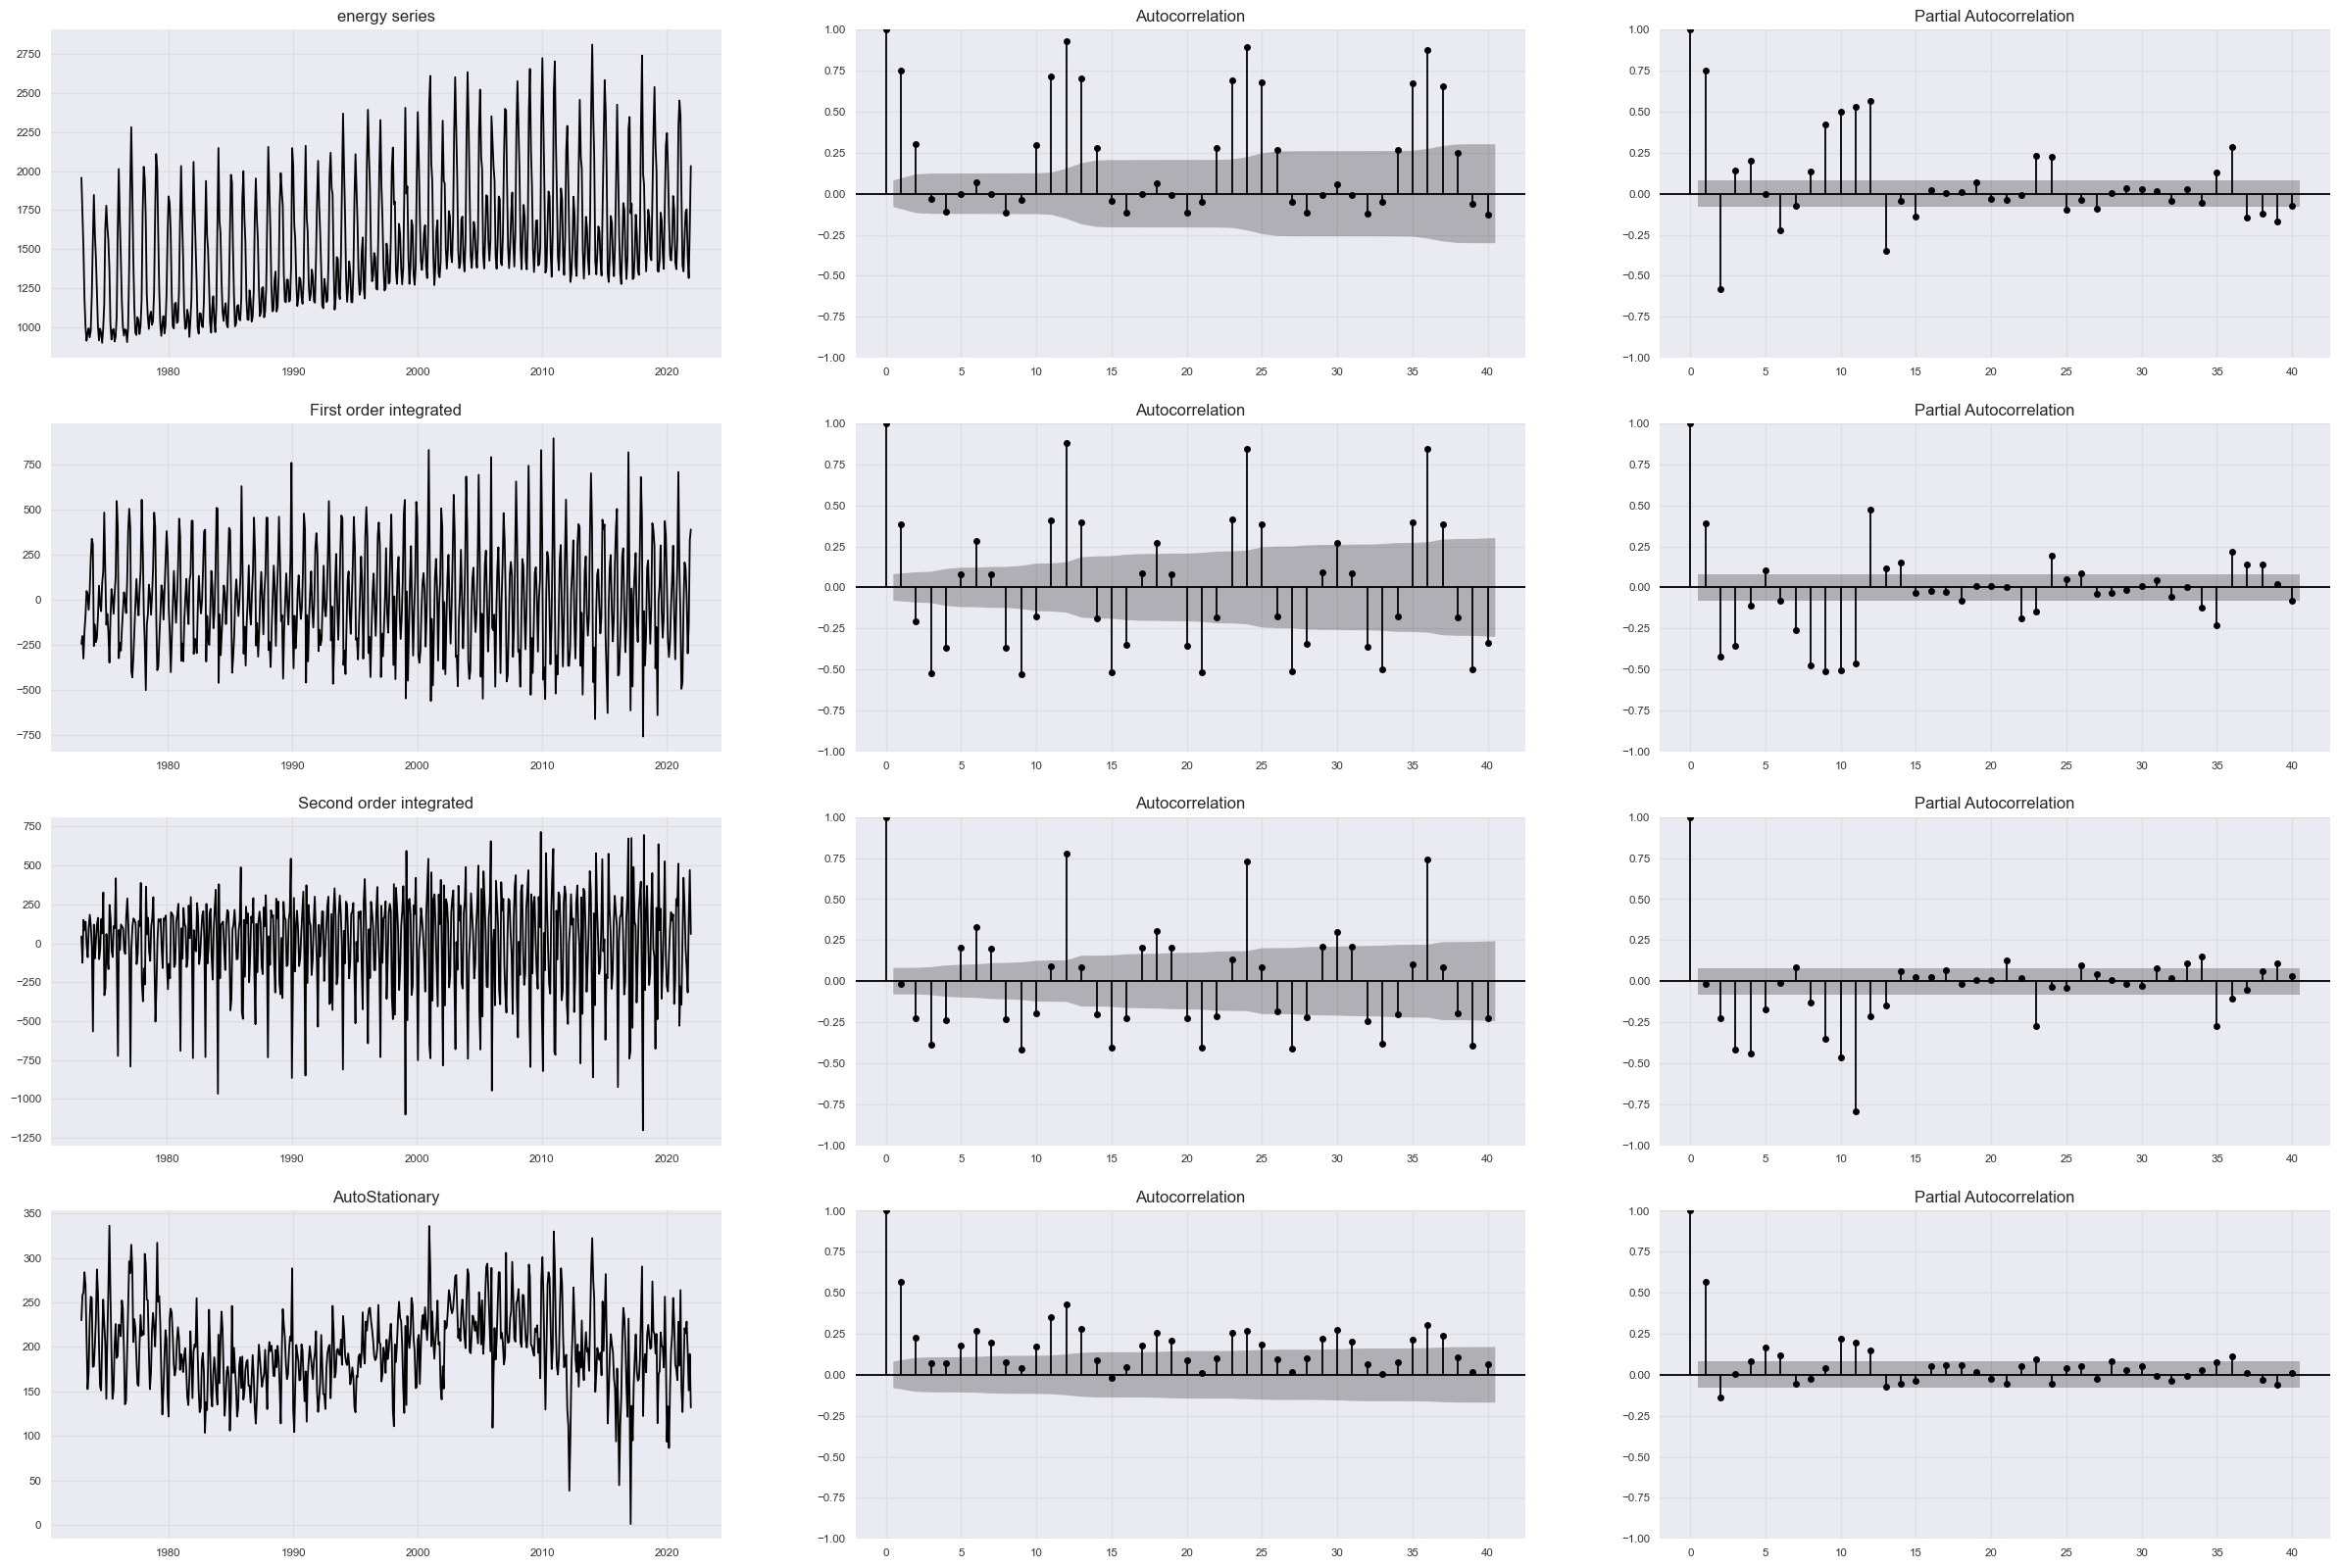

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(30, 20))

# plot original series
axes[0,0].plot(energy)
axes[0,0].set_title("energy series")
print(plot_acf(energy, ax=axes[0,1], lags=40))
print(plot_pacf(energy, ax=axes[0,2], lags=40))

# plot first order integrated series
first_ord_diff = energy.diff().dropna()
axes[1,0].plot(first_ord_diff)
axes[1,0].set_title("First order integrated")
print(plot_acf(first_ord_diff, ax=axes[1,1], lags=40))
print(plot_pacf(first_ord_diff, ax=axes[1,2], lags=40))

# plot first order integrated series
second_ord_diff = energy.diff().diff().dropna()
axes[2,0].plot(second_ord_diff)
axes[2,0].set_title("Second order integrated")
print(plot_acf(second_ord_diff, ax=axes[2,1], lags=40))
print(plot_pacf(second_ord_diff, ax=axes[2,2], lags=40))

# Subtract Rolling Mean series
axes[3,0].plot(y_stat)
axes[3,0].set_title("AutoStationary")
print(plot_acf(y_stat, ax=axes[3,1], lags=40))
print(plot_pacf(y_stat, ax=axes[3,2], lags=40))

# Splitting Data

In [8]:
def split_data(data, train_split, val_split, test_split):
    l = len(data)
    train_idx = round(l * train_split)
    val_idx = round(l * (train_split + val_split))
    
    train, val, test = data[:train_idx], data[train_idx:val_idx], data[val_idx:]
    
    print(f'train: {len(train)}, val: {len(val)}, test: {len(test)}')
    
    return train, val, test

In [9]:
train_data, val_data, test_data = split_data(energy, 0.7, 0.15, 0.15)
# train_tf_data, val_tf_data, test_tf_data = split_data(y_stat, 0.7, 0.15, 0.15)

train: 412, val: 88, test: 88


In [10]:
pred_df = pd.concat([train_data, val_data])
metric_record = []

ts_train = TimeSeries.from_dataframe(train_data)
ts_val = TimeSeries.from_dataframe(val_data)
ts_test = TimeSeries.from_dataframe(test_data)

In [11]:
# ts_train_tf = TimeSeries.from_dataframe(pd.DataFrame(train_tf_data, columns=['y']))
# ts_val_tf = TimeSeries.from_dataframe(pd.DataFrame(val_tf_data, columns=['y']))
# ts_test_tf = TimeSeries.from_dataframe(pd.DataFrame(test_tf_data, columns=['y']))

# Helper Functions
## Eval Model & Format y Pred Functions

In [12]:
def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "Forecast Bias": forecast_bias(actual_series = ts_test, pred_series = y_pred)
    }

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

## Plotting Forecast

### Using Matplotlib 

In [27]:
def plot_forecast_mb(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)
    
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = plt.cm.Dark2(np.linspace(0, 1, len(forecast_columns)))
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot actual consumption
    ax.plot(pred_df[mask].index, pred_df[mask].y, label='Actual Consumption', color='grey', alpha=0.8)
    
    # Plot forecasted values
    for col, display_col, color in zip(forecast_columns, forecast_display_names, colors):
        ax.plot(pred_df[mask].index, pred_df.loc[mask, col], label=display_col, linestyle='--', color='red')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    plt.grid(True)
    plt.title('Forecasted Values vs. Actual Consumption')
    plt.show()

### Using Plotly

In [14]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [15]:
from itertools import cycle
def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    # colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    # colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Safe]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
#     change y to your time series column
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].y,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.3")),
                        name='Actual Consumption'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

# Statistical Method Models
## Naive Forecast

In [16]:
name = "Naive"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "naive_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [17]:
fig = plot_forecast(pred_df, forecast_columns=["naive_predictions"], forecast_display_names=['Naive Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/naive.png")
fig.show()

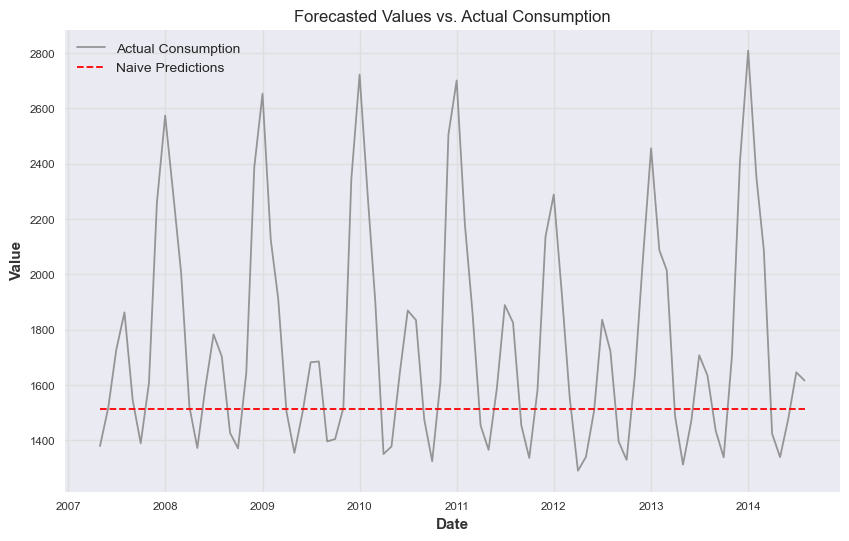

In [28]:
plot_forecast_mb(pred_df, forecast_columns=["naive_predictions"], forecast_display_names=['Naive Predictions'])

## Moving Averages

In [19]:
name = "Moving Average Forecast"
naive_model = NaiveMovingAverage(window=12)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "moving_average_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [20]:
fig = plot_forecast(pred_df, forecast_columns=["moving_average_predictions"], forecast_display_names=['Moving Average Predictions'])
fig = format_plot(fig, title=f"Moving Average: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/moving_average.png")
fig.show()

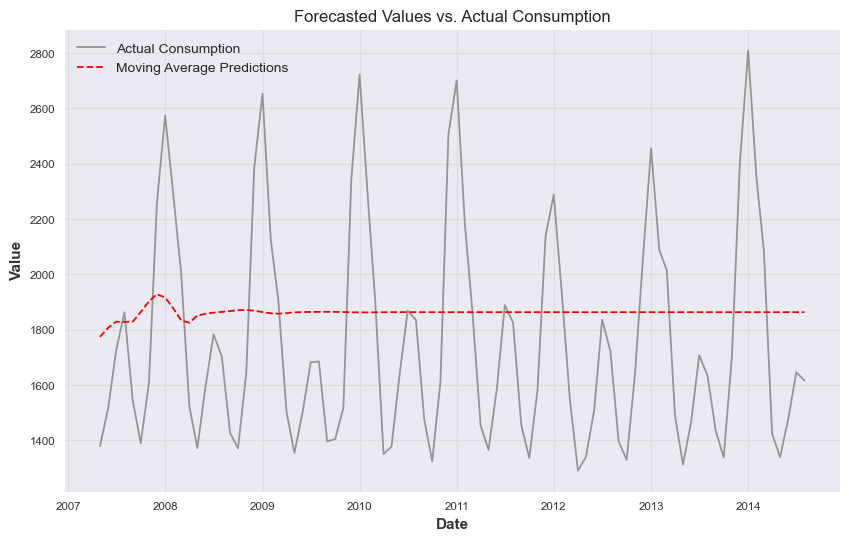

In [29]:
plot_forecast_mb(pred_df, forecast_columns=["moving_average_predictions"], forecast_display_names=['Moving Average Predictions'])

## Seasonal Naive Forecast

In [22]:
name = "Seasonal Naive Forecast"
naive_model = NaiveSeasonal(K=12)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "snaive_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [23]:
fig = plot_forecast(pred_df, forecast_columns=["snaive_predictions"], forecast_display_names=['Seasonal Naive Predictions'])
fig = format_plot(fig, title=f"Seasonal Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/seasonal_naive.png")
fig.show()

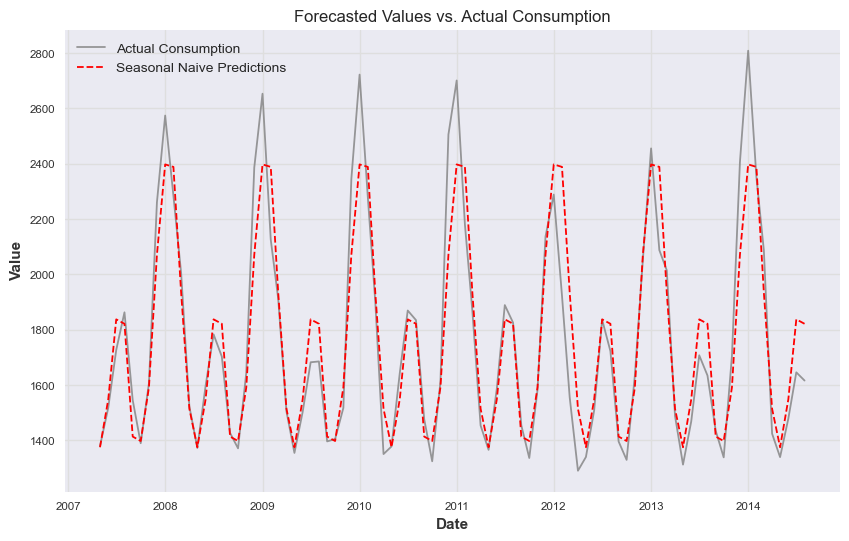

In [30]:
plot_forecast_mb(pred_df, forecast_columns=["snaive_predictions"], forecast_display_names=['Seasonal Naive Predictions'])

## Exponential Smoothing Forecast

In [31]:
import warnings

In [32]:
name = "Exponential Smoothing"
# Suppress FutureWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    ets_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12, random_state=42)
    with LogTime() as timer:
        y_pred, metrics = eval_model(ets_model, ts_train, ts_val, name=name)
    metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "ets_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [33]:
fig = plot_forecast(pred_df, forecast_columns=["ets_predictions"], forecast_display_names=['Exponential Smoothing Predictions'])
fig = format_plot(fig, title=f"Exponential Smoothing: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/ets.png")
fig.show()

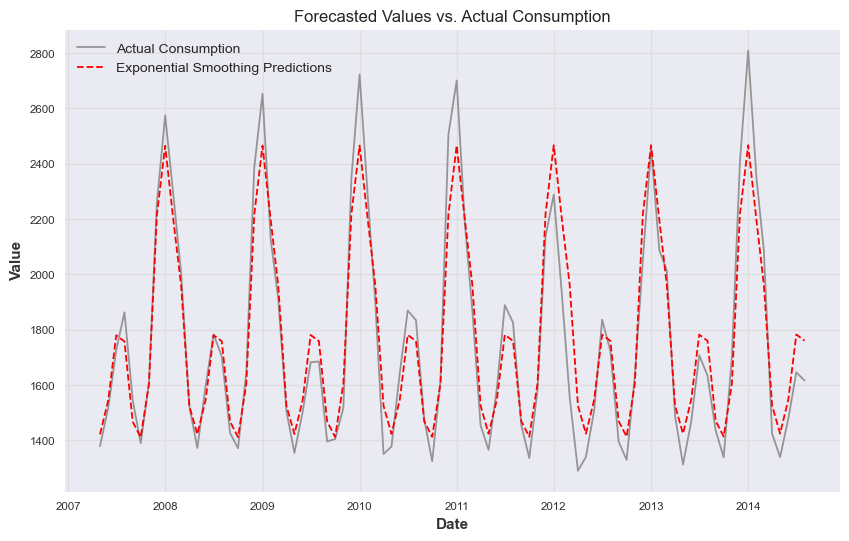

In [34]:
plot_forecast_mb(pred_df, forecast_columns=["ets_predictions"], forecast_display_names=['Exponential Smoothing Predictions'])

## Theta

In [35]:
name = "Theta"
theta_model = Theta(theta=3, seasonality_period=12, season_mode=SeasonalityMode.ADDITIVE)
with LogTime() as timer:
    y_pred, metrics = eval_model(theta_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "theta_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [36]:
fig = plot_forecast(pred_df, forecast_columns=["theta_predictions"], forecast_display_names=['Theta Predictions'])
fig = format_plot(fig, title=f"Theta: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/theta.png")
fig.show()

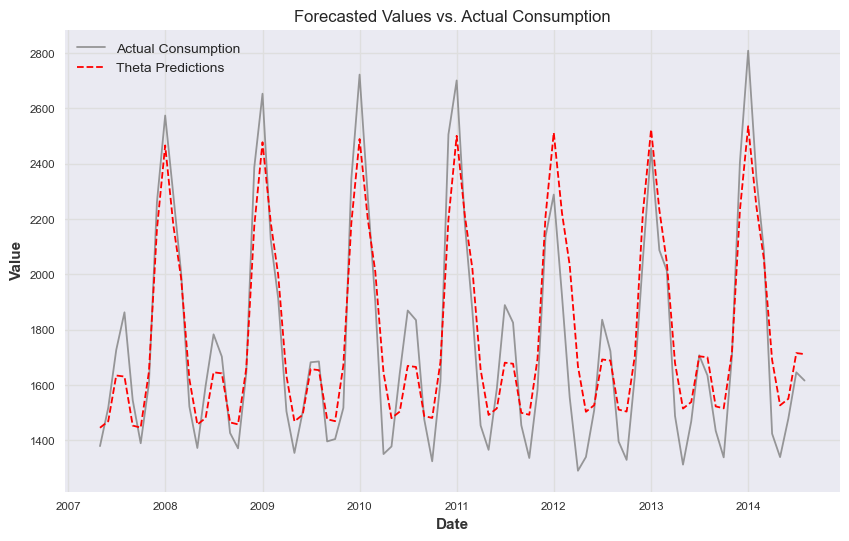

In [37]:
plot_forecast_mb(pred_df, forecast_columns=["theta_predictions"], forecast_display_names=['Theta Predictions'])

## FFT

In [38]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=12, trend="poly", trend_poly_degree=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(fft_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "fft_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [39]:
fig = plot_forecast(pred_df, forecast_columns=["fft_predictions"], forecast_display_names=['FFT Predictions'])
fig = format_plot(fig, title=f"FFT: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/fft.png")
fig.show()

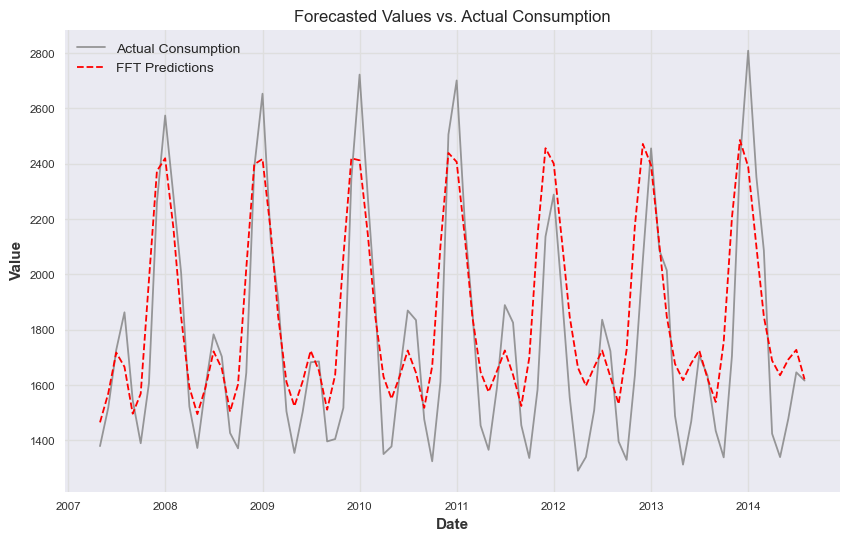

In [40]:
plot_forecast_mb(pred_df, forecast_columns=["fft_predictions"], forecast_display_names=['FFT Predictions'])

## ARIMA

In [41]:
name = "ARIMA"
#Not using AutoARIMA because it just takes too much time for long time series
# arima_model = AutoARIMA(max_p=5, max_q=3, m=48, seasonal=False)
arima_model = ARIMA(p=1, d=1, q=1, seasonal_order=(1, 1, 1, 12))
# Taking only latest 8000 points for training (Time constraints)
# Reduce 8000 if it is taking too much time or consuming all the memory
with LogTime() as timer:
    y_pred, metrics = eval_model(arima_model, ts_train, ts_val,  name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "arima_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 2 seconds


In [42]:
fig = plot_forecast(pred_df, forecast_columns=["arima_predictions"], forecast_display_names=['ARIMA Predictions'])
fig = format_plot(fig, title=f"ARIMA: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/arima.png")
fig.show()

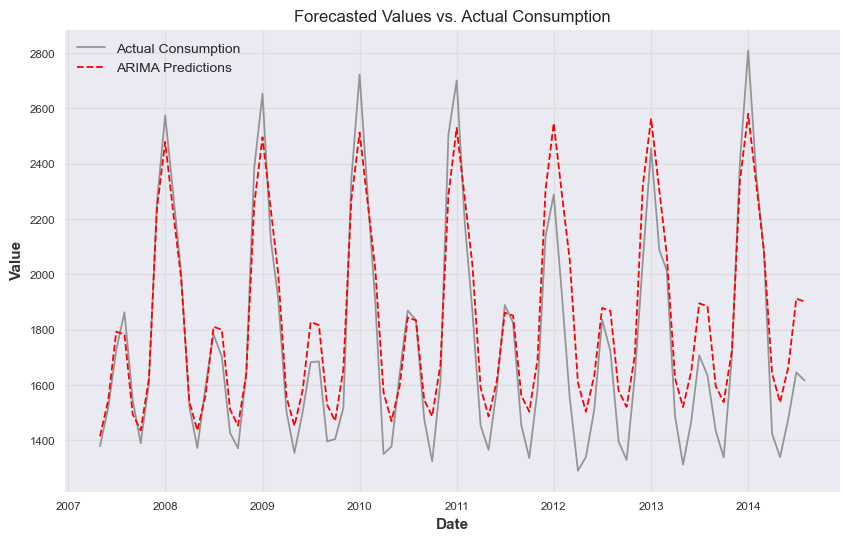

In [43]:
 plot_forecast_mb(pred_df, forecast_columns=["arima_predictions"], forecast_display_names=['ARIMA Predictions'])

## Auto ARIMA

In [44]:
name = "Auto ARIMA"

auto_arima_model = AutoARIMA(max_p=4, max_q=4, m=12, seasonal=True, max_P=3, max_Q=3, trace=True)
# arima_model = ARIMA(p=1, d=1, q=1, seasonal_order=(1, 1, 1, 12))

with LogTime() as timer:
    y_pred, metrics = eval_model(auto_arima_model, ts_train, ts_val,  name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "auto_arima_predictions")
pred_df = pred_df.join(y_pred)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.82 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5761.332, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5429.303, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5759.340, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5665.506, Time=0.49 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4910.352, Time=2.42 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5072.772, Time=0.85 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=4912.352, Time=4.24 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=5356.136, Time=1.83 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=5002.566, Time=2.65 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=7.48 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4954.291, Time=1.46 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : 

In [45]:
fig = plot_forecast(pred_df, forecast_columns=["auto_arima_predictions"], forecast_display_names=['Auto ARIMA Predictions'])
fig = format_plot(fig, title=f"Auto ARIMA: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/auto_arima.png")
fig.show()

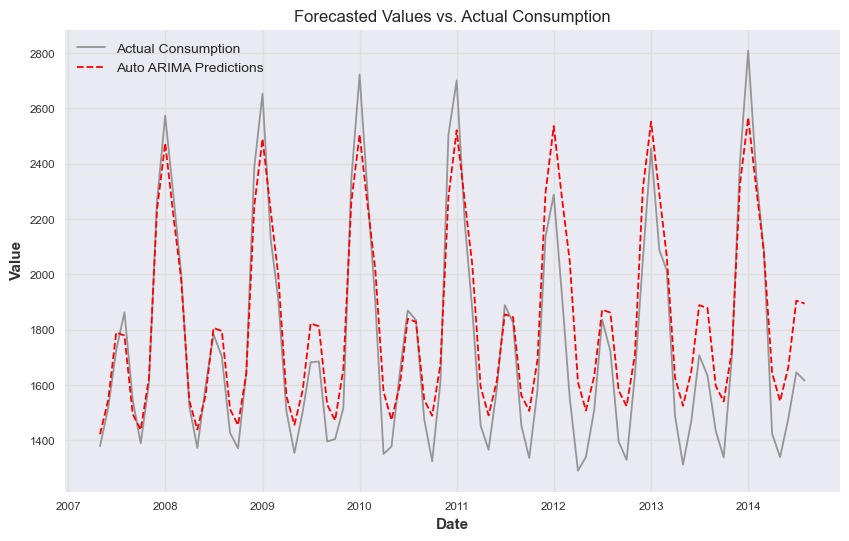

In [46]:
plot_forecast_mb(pred_df, forecast_columns=["auto_arima_predictions"], forecast_display_names=['Auto ARIMA Predictions'])

# Evaluation Model Results

In [47]:
baseline_metrics_df = (pd.DataFrame(metric_record)).sort_values("MAE", ascending=True)
baseline_metrics_df

Algorithm         MAE            MSE      MASE  \
3    Exponential Smoothing   90.198792   13799.281374  0.425768   
2  Seasonal Naive Forecast  104.870466   23081.606122  0.495023   
6                    ARIMA  122.157820   23002.627842  0.576625   
7               Auto ARIMA  122.569332   22829.289327  0.578567   
4                    Theta  123.840508   22781.101969  0.584568   
5                      FFT  180.774467   52573.342001  0.853314   
0                    Naive  327.778136  216190.615413  1.547220   
1  Moving Average Forecast  349.654397  162483.024905  1.650483   

   Forecast Bias  Time Elapsed  
3      -0.676061      0.658217  
2      -0.397419      0.195661  
6      -4.635008      2.194688  
7      -4.481285     84.194298  
4      -1.553763      0.264019  
5      -4.963114      0.264541  
0      14.031883      0.199907  
1      -5.693713      0.213828

In [48]:
baseline_metrics_df.to_csv("energy-consumption/datasets/output/baseline_metrics.csv")